In [1]:
!pip install python-igraph
!pip install plotly

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import folium 
from folium import plugins
# from folium.plugins import HeatMap

import json 
from datetime import datetime

import os

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 
!apt -qq -y install fonts-nanum
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [3]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### PatientInfo 데이터를 활용해서, 감염을 퍼트린 시초(이후 전파자라고 칭함)를 알아보자.


In [5]:
patientInfo = pd.read_csv('/content/gdrive/My Drive/dacon/COVID_19/PatientInfo.csv')

In [6]:
patientInfo.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,서울,강서구,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,서울,중랑구,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,서울,종로구,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,서울,마포구,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,서울,성북구,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [7]:
#infection_case가 contact with patient 인 경우만 분리
patient_who_infected_by_others = patientInfo[patientInfo['infection_case'] == 'contact with patient'].reset_index().drop(["index"], axis = 1)
patient_who_infected_by_others = patient_who_infected_by_others[['patient_id','sex','age','country','province','city','infection_case','infected_by']]
patient_who_infected_by_others['province_city'] = patient_who_infected_by_others['province'] + ' ' + patient_who_infected_by_others['city']
patient_who_infected_by_others = patient_who_infected_by_others.drop(["province","city"], axis = 1)
patient_who_infected_by_others.head()

,patient_id,sex,age,country,infection_case,infected_by,province_city
0,1000000003,male,50s,Korea,contact with patient,2002000001,서울 종로구
1,1000000005,female,20s,Korea,contact with patient,1000000002,서울 성북구
2,1000000006,female,50s,Korea,contact with patient,1000000003,서울 종로구
3,1000000007,male,20s,Korea,contact with patient,1000000003,서울 종로구
4,1000000010,female,60s,Korea,contact with patient,1000000003,서울 성북구


In [8]:
patient_who_infected_by_others['infected_by'].isnull().sum() / patient_who_infected_by_others['infected_by'].size

0.23229813664596274

In [9]:
patient_who_infected_by_others = patient_who_infected_by_others.dropna(axis = 0)
patient_who_infected_by_others.head()

,patient_id,sex,age,country,infection_case,infected_by,province_city
0,1000000003,male,50s,Korea,contact with patient,2002000001,서울 종로구
1,1000000005,female,20s,Korea,contact with patient,1000000002,서울 성북구
2,1000000006,female,50s,Korea,contact with patient,1000000003,서울 종로구
3,1000000007,male,20s,Korea,contact with patient,1000000003,서울 종로구
4,1000000010,female,60s,Korea,contact with patient,1000000003,서울 성북구


In [10]:
patient_who_infected_by_others = patient_who_infected_by_others.reset_index().drop(['index'], axis = 1)

In [11]:
patient_who_infected_by_others.head()
trace = dict()
for i in range(len(patient_who_infected_by_others)):
  infected = patient_who_infected_by_others['infected_by'][i]
  patient = patient_who_infected_by_others['patient_id'][i]
  if infected in trace:
    trace[infected].append(patient)
  else:
    trace[infected] = [patient]


In [12]:
getMax = 0
for key, value in trace.items():
  if len(value) > getMax:
    getMax = len(value)
getMax = getMax * 2 + 1

In [13]:
for key in trace:
  if len(trace[key]) < getMax:
    while len(trace[key]) < getMax:
      trace[key].append(0) 

size = []
for key,value in trace.items():
  size.append(len(value))


trace_df = pd.DataFrame(trace)
trace_df = trace_df.T
trace_df = trace_df.reset_index()
trace_df.rename(columns={'index':'beginning'}, inplace = True)
trace_df.to_csv('/content/gdrive/My Drive/dacon/trace_testset.csv')


In [14]:
test_trace_df = pd.read_csv('/content/gdrive/My Drive/dacon/trace_testset.csv')
test_trace_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [15]:
test_trace_df.head()

,beginning,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102
0,2002000001,1000000003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1000000002,1000000005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1000000003,1000000006,1000000007,1000000010,1000000017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1000000017,1000000013,1000000016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1000000013,1000000014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


전파자가 같은 값들을 해당 전파자에 넣는다.  
결국, 전파자가 같은 감염자들이 key를 전파자로 하여 value에 모두 모이게 된다.  
이를 다시 Dataframe으로 나타낸다.

In [16]:
# for i in range(len(test_trace_df)):
i = 0
while i < len(test_trace_df):
  for j in range(103):
    beginning = list(test_trace_df['beginning'][:])
    if test_trace_df[str(j)][i] == 0:
      continue
    if test_trace_df[str(j)][i] in beginning:
      idx = beginning.index(test_trace_df[str(j)][i])
      tmp = list(test_trace_df.loc[idx])
      for k in range(len(tmp)):
        if tmp[k] == 0:
          tmp = tmp[1:k]
          break
      for l in range(len(test_trace_df.loc[idx])):
        if test_trace_df.loc[i][l] == 0:
          test_trace_df.loc[i][l:l+len(tmp)] = tmp
          test_trace_df.drop([idx], inplace = True)
          test_trace_df = test_trace_df.reset_index()
          test_trace_df.drop(["index"],axis= 1,inplace=True)
          break
  i += 1

모두 0을 갖는 열을 삭제한다.  
처음에 각 행의 길이를 getMax * 2 + 1로 설정한 이유는, getMax 길이를 갖는 전파자가 다른 전파자에 의해 감염된 경우일 수도 있기 때문에 가질 수 있는 최대 길이의 +1을 해주었다.  

In [17]:
dropcol = []
for i in range(0,103):
  tmp = list(test_trace_df[str(i)])
  if len(set(tmp)) == 1 and tmp[0] == 0:
    dropcol.append(i)

while dropcol:
  j = dropcol.pop()
  test_trace_df.drop([str(j)],axis=1,inplace= True)


test_trace_df.head()

,beginning,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
0,2002000001,1000000003,1000000006,1000000007,1000000010,1000000017,1000000013,1000000016,1000000014,1000000021,2000000019,1000000019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1000000002,1000000005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1000000031,1000000033,1000000034,1000000037,1000000045,1000000067,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1000000041,1000000046,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1000000047,1000000064,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
test_trace_df.to_csv('/content/gdrive/My Drive/dacon/update_trace_testset_drop_all_zero.csv')

전파자들의 정보를 알아보기 위해, dictionary 형태로 가져온 후 Df로 변경하는 과정을 거쳤다. 이 때 가져오는 정보는 성별, 나이대, 지역, 감염 원인이다.

In [19]:
bg = list(test_trace_df['beginning'])

info_about_beginning = dict()
for p_id in bg:
  for i in range(len(patientInfo)):
    if int(patientInfo['patient_id'][i]) == int(p_id):
      info_about_beginning[p_id] = [patientInfo['sex'][i],patientInfo['age'][i],patientInfo['province'][i], patientInfo['city'][i], patientInfo['infection_case'][i]]
      break

In [20]:
info_about_beginning_df = pd.DataFrame(info_about_beginning)
info_about_beginning_df = info_about_beginning_df.T
info_about_beginning_df = info_about_beginning_df.reset_index()
info_about_beginning_df.rename(columns={'index':'beginning'}, inplace = True)
info_about_beginning_df.columns = ["beginning","sex","age","province","city","infection_case"]
info_about_beginning_df.head()

,beginning,sex,age,province,city,infection_case
0,1000000002,male,30s,서울,중랑구,overseas inflow
1,1000000031,male,50s,서울,송파구,etc
2,1000000041,male,50s,서울,강동구,etc
3,1000000047,male,20s,서울,강남구,Shincheonji Church
4,1000000068,female,20s,서울,강남구,etc


하지만 아래 check를 통해 확인할 수 있듯이, 전파자임에도 불구하고 '접촉'을 통해 감염된 환자들이 37명이나 존재했다.

In [21]:
check = info_about_beginning_df[info_about_beginning_df['infection_case'] == 'contact with patient']
print(len(check))
check.head()

37


,beginning,sex,age,province,city,infection_case
5,1000000111,male,30s,서울,강북구,contact with patient
6,1000000115,female,50s,서울,양천구,contact with patient
9,1000000108,male,40s,서울,기타,contact with patient
21,1000000264,male,40s,서울,강서구,contact with patient
49,1100000002,female,50s,부산,해운대구,contact with patient


37명은, 전체 전파자 수 대비하여 보았을 때 13% 정도이다.

In [22]:
print(len(check)/len(info_about_beginning_df))

0.13405797101449277


In [23]:
import collections
infection_case_list = list(info_about_beginning_df['infection_case'])
infection_case_list = collections.Counter(infection_case_list)
infection_most_common = list(infection_case_list.most_common(15))

In [24]:
tmp = dict()
for i in range(len(infection_most_common)):
  key = infection_most_common[i][0]
  value = infection_most_common[i][1]
  if type(key) is float:
    key = 'Unknown'
  tmp[key] = value
print(tmp)

{'etc': 103, 'overseas inflow': 52, 'contact with patient': 37, 'gym facility in Cheonan': 14, 'Shincheonji Church': 12, 'Unknown': 11, 'Itaewon Clubs': 11, 'Coupang Logistics Center': 8, 'Dongan Church': 5, 'Onchun Church': 5, 'Guro-gu Call Center': 4, 'Dunsan Electronics Town': 4, 'Orange Town': 2, 'gym facility in Sejong': 1, 'Ministry of Oceans and Fisheries': 1}


In [25]:
infection_most_common_df = pd.DataFrame(tmp, index = (0,len(tmp)))
infection_most_common_df = infection_most_common_df.T
infection_most_common_df.drop([15],axis=1,inplace=True)
infection_most_common_df = infection_most_common_df.reset_index()
infection_most_common_df.columns = ["infection case","number of cases"]
infection_most_common_df

,infection case,number of cases
0,etc,103
1,overseas inflow,52
2,contact with patient,37
3,gym facility in Cheonan,14
4,Shincheonji Church,12
5,Unknown,11
6,Itaewon Clubs,11
7,Coupang Logistics Center,8
8,Dongan Church,5
9,Onchun Church,5


In [26]:
infection_most_common_df.set_index("infection case")

,number of cases
infection case,
etc,103
overseas inflow,52
contact with patient,37
gym facility in Cheonan,14
Shincheonji Church,12
Unknown,11
Itaewon Clubs,11
Coupang Logistics Center,8
Dongan Church,5


연쇄 감염을 일으킨 원인 Top 15

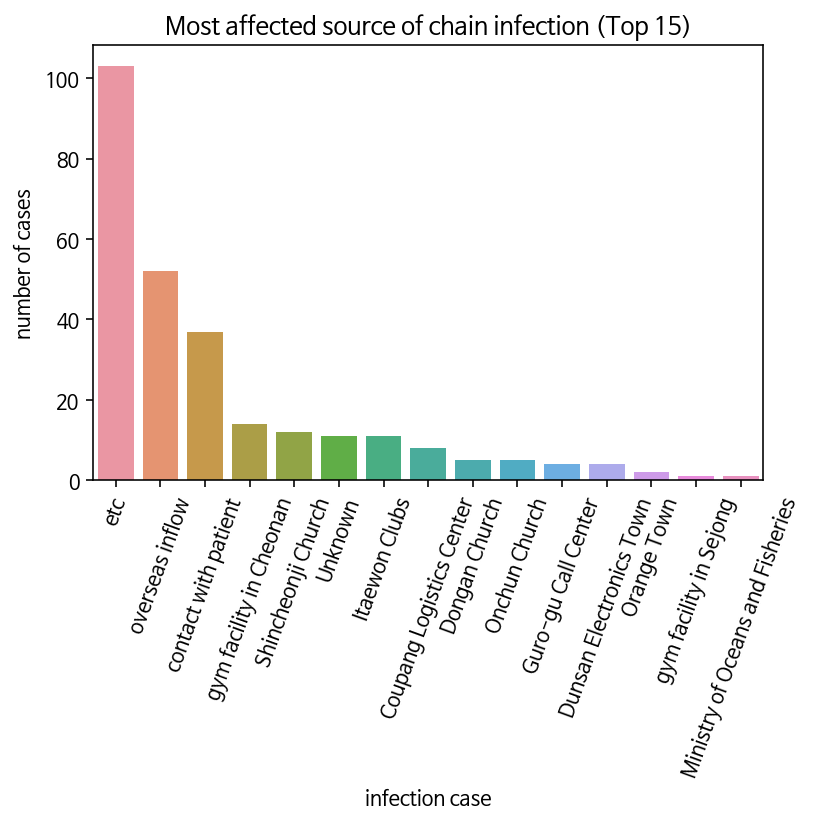

In [27]:
sns.barplot(x='infection case',y='number of cases',data=infection_most_common_df)
plt.title('Most affected source of chain infection (Top 15)')
plt.xticks(rotation=70)
plt.show()


# fig=px.bar(infection_most_common_df,x='infection case',y='number of cases')
# fig.update_layout(
#     title={
#         'text': "Most affected source of chain infection (Top 15)",
#         'y':1,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'})
# fig.show()

In [28]:
info_about_beginning_df['location'] = info_about_beginning_df['province'] + ' ' + info_about_beginning_df['city']

In [29]:
info_about_beginning_df.drop(["province","city"], axis = 1, inplace=True)

In [30]:
info_about_beginning_df.head()

,beginning,sex,age,infection_case,location
0,1000000002,male,30s,overseas inflow,서울 중랑구
1,1000000031,male,50s,etc,서울 송파구
2,1000000041,male,50s,etc,서울 강동구
3,1000000047,male,20s,Shincheonji Church,서울 강남구
4,1000000068,female,20s,etc,서울 강남구


In [31]:
infection_location = info_about_beginning_df[['location']]
infection_location['count'] = 1
infection_location = infection_location.groupby(['location']).sum().reset_index()
infection_location

,location,count
0,경기도 고양시,3
1,경기도 광주,2
2,경기도 구리시,2
3,경기도 군포시,2
4,경기도 김포시,1
...,...,...
91,충청남도 아산시,4
92,충청남도 천안시,21
93,충청북도 괴산,1
94,충청북도 청주시,1


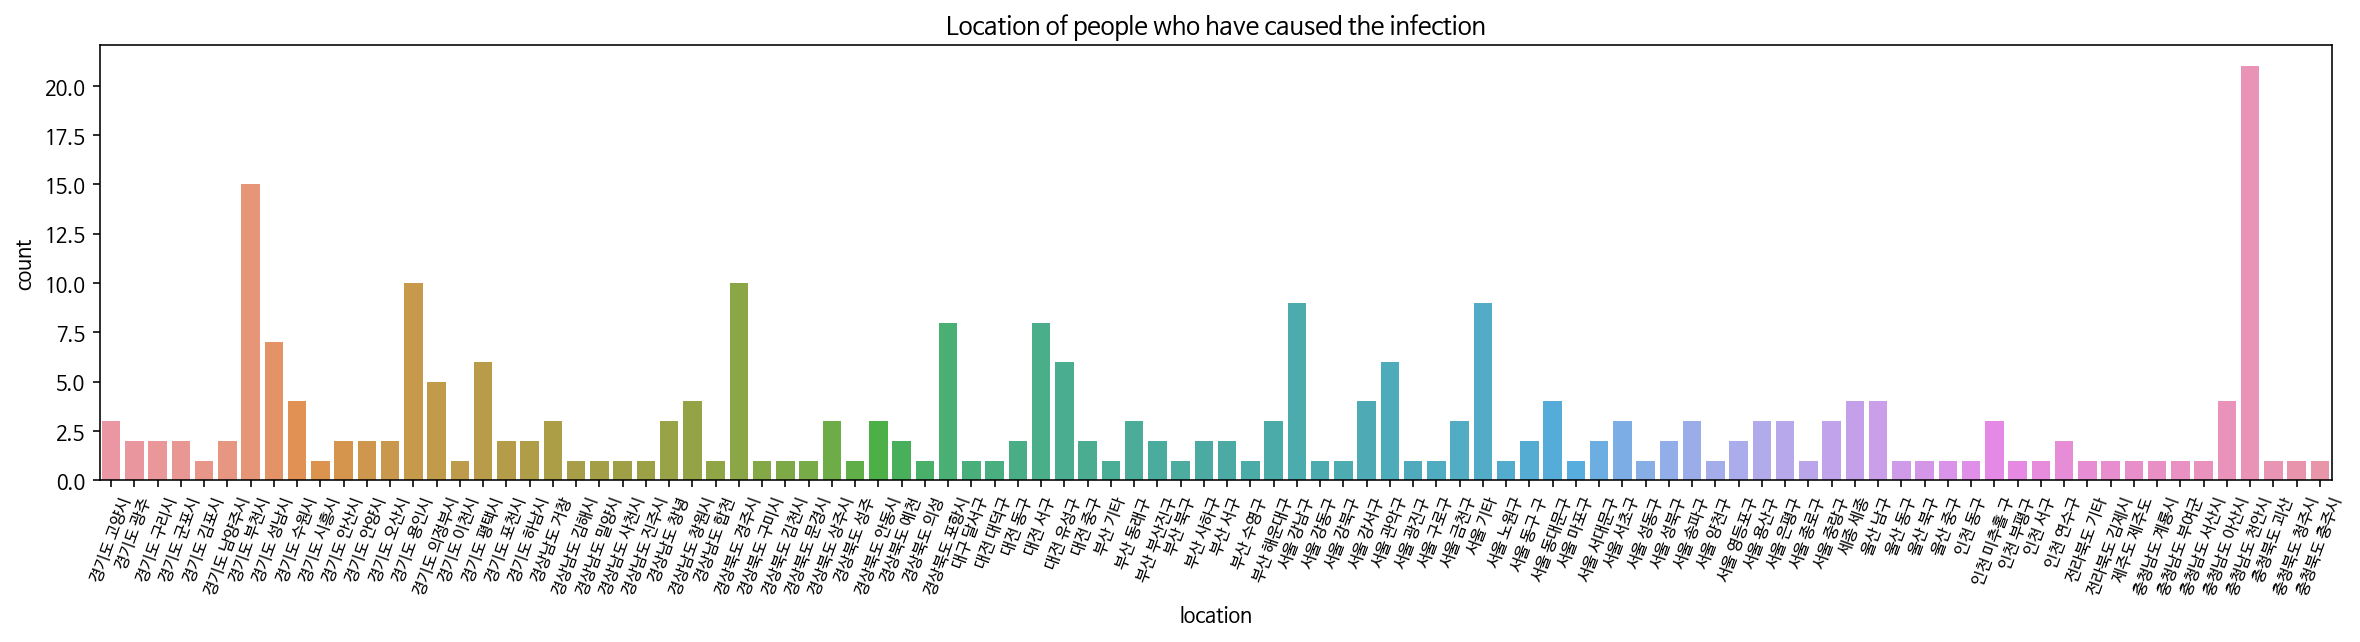

In [32]:
plt.figure(figsize=(20,4)) 
sns.barplot(x='location',y='count',data=infection_location)

plt.title('Location of people who have caused the infection')
plt.xticks(rotation=70, fontsize = 8)
plt.show()

In [33]:
infection_location.sort_values(by='count', ascending=False, inplace= True)
infection_location.head()

,location,count
92,충청남도 천안시,21
6,경기도 부천시,15
13,경기도 용인시,10
27,경상북도 경주시,10
51,서울 강남구,9


전파자의 위치는 **충청남도 천안시, 경기도 부천시, 경기도 용인시, 경상북도 경주시, 서울 강남구** 가 Top 5 였다.

In [34]:
patient_who_infected_by_others.head()

,patient_id,sex,age,country,infection_case,infected_by,province_city
0,1000000003,male,50s,Korea,contact with patient,2002000001,서울 종로구
1,1000000005,female,20s,Korea,contact with patient,1000000002,서울 성북구
2,1000000006,female,50s,Korea,contact with patient,1000000003,서울 종로구
3,1000000007,male,20s,Korea,contact with patient,1000000003,서울 종로구
4,1000000010,female,60s,Korea,contact with patient,1000000003,서울 성북구


접촉자들의 위치 순위를 알아보기 위해서 앞선 test_trace_df의 beginning에 속해있는 사람들을 제외한 patient_who_infected_by_others를 만든다.

In [35]:
bg = list(test_trace_df['beginning'])
p_id = list(patient_who_infected_by_others['patient_id'])
remove_idx = []
for p in bg:
  if p in p_id:
    idx = p_id.index(p)
    remove_idx.append(idx)


infected_by_others_remove_bg = patient_who_infected_by_others
for idx in remove_idx:
  infected_by_others_remove_bg.drop([idx], inplace=True)

infected_by_others_remove_bg.head()

,patient_id,sex,age,country,infection_case,infected_by,province_city
0,1000000003,male,50s,Korea,contact with patient,2002000001,서울 종로구
1,1000000005,female,20s,Korea,contact with patient,1000000002,서울 성북구
2,1000000006,female,50s,Korea,contact with patient,1000000003,서울 종로구
3,1000000007,male,20s,Korea,contact with patient,1000000003,서울 종로구
4,1000000010,female,60s,Korea,contact with patient,1000000003,서울 성북구


In [36]:
infected_by_others_remove_bg_loc = infected_by_others_remove_bg[['province_city']]
infected_by_others_remove_bg_loc['count'] = 1
infected_by_others_remove_bg_loc = infected_by_others_remove_bg_loc.groupby(['province_city']).sum().reset_index()
infected_by_others_remove_bg_loc.head()

,province_city,count
0,경기도 고양시,10
1,경기도 광명시,10
2,경기도 광주,14
3,경기도 구리시,1
4,경기도 군포시,26


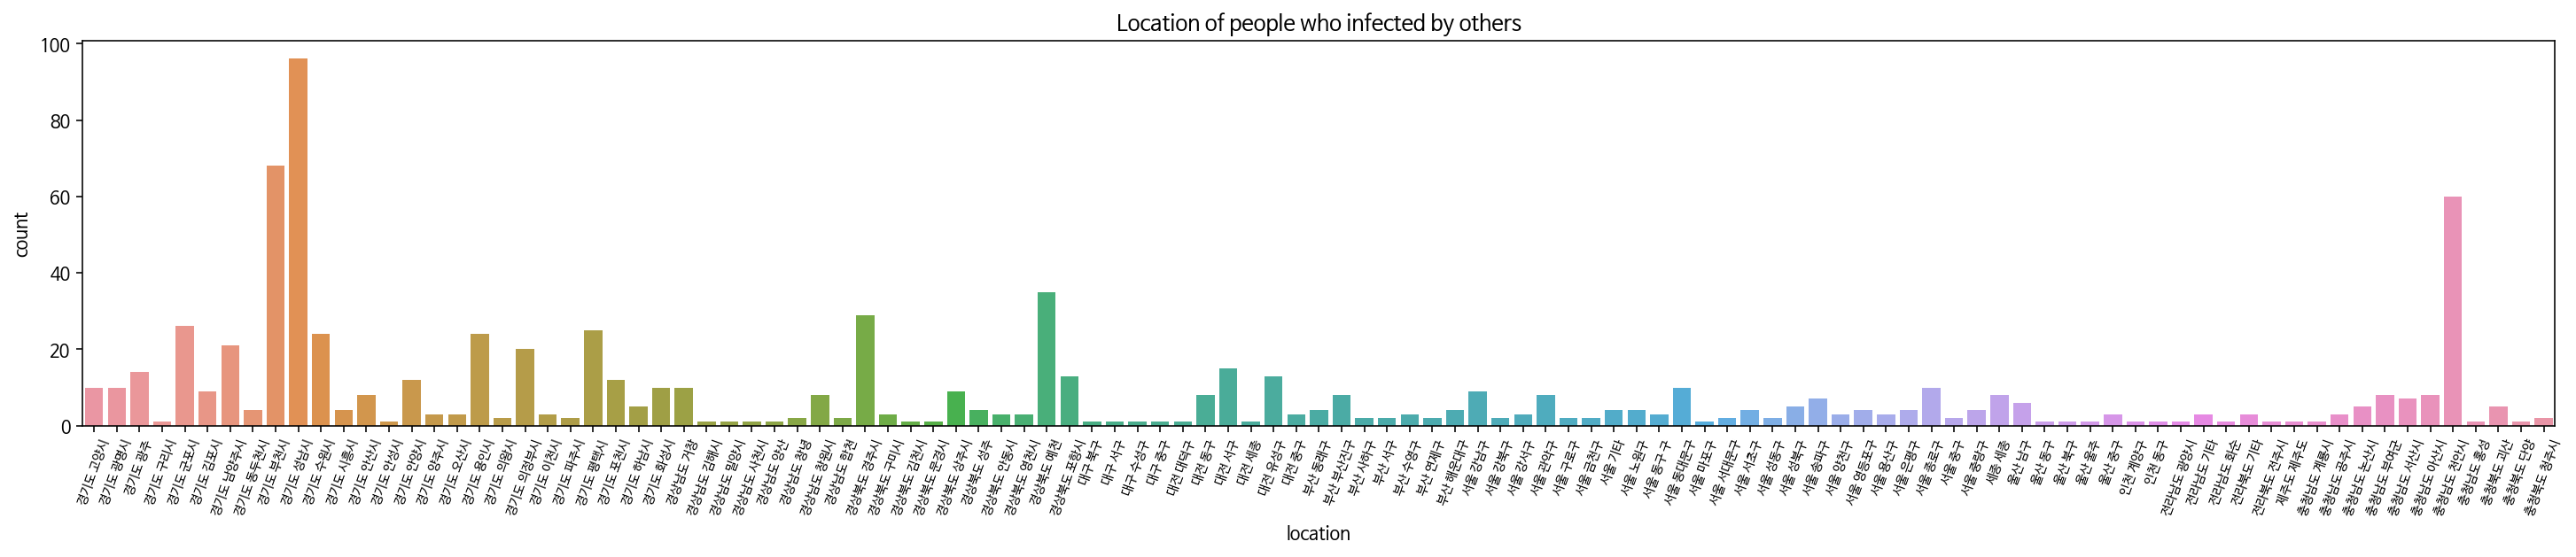

In [37]:
plt.figure(figsize=(25,4)) 
sns.barplot(x='province_city',y='count',data=infected_by_others_remove_bg_loc)

plt.title('Location of people who infected by others')
plt.xticks(rotation=70, fontsize = 7)
plt.xlabel('location')
plt.show()

In [38]:
infected_by_others_remove_bg_loc.sort_values(by='count', ascending=False, inplace= True)
infected_by_others_remove_bg_loc.head()

,province_city,count
9,경기도 성남시,96
8,경기도 부천시,68
104,충청남도 천안시,60
42,경상북도 예천,35
34,경상북도 경주시,29


In [39]:
infection_location.columns = ["location","Number of people who have infected others"]
infected_by_others_remove_bg_loc.columns = ["location","Number of people who infected by others"]
infection_merge = pd.merge(infection_location, infected_by_others_remove_bg_loc, how='left',on='location')
infection_merge.head()

,location,Number of people who have infected others,Number of people who infected by others
0,충청남도 천안시,21,60.0
1,경기도 부천시,15,68.0
2,경기도 용인시,10,24.0
3,경상북도 경주시,10,29.0
4,서울 강남구,9,9.0


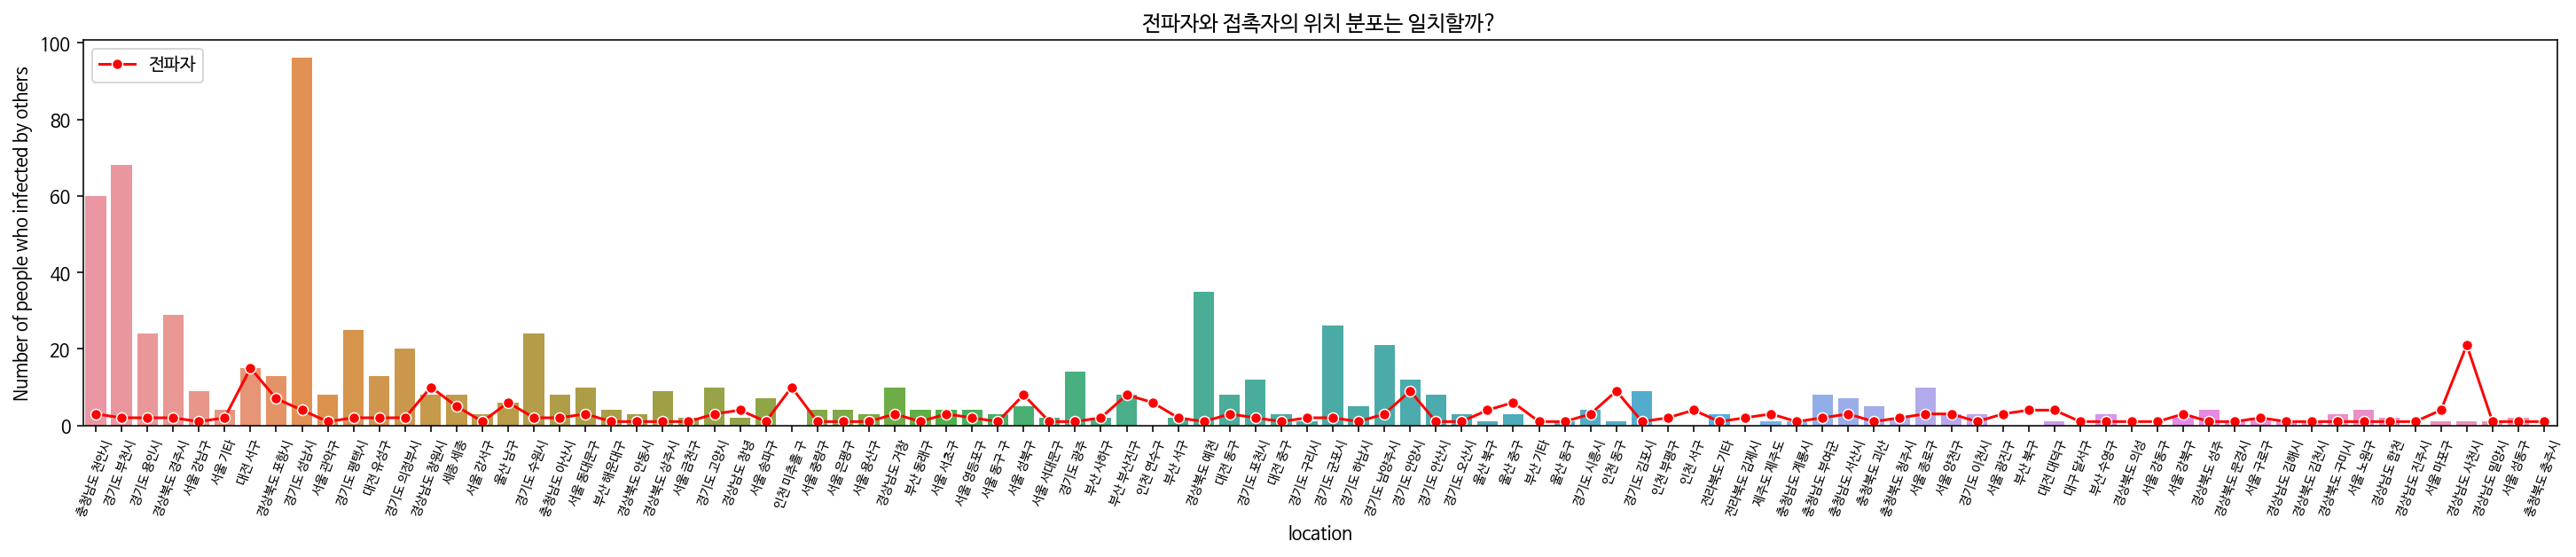

In [40]:
plt.figure(figsize=(25,4)) 
sns.lineplot(x='location', y='Number of people who have infected others', data=infection_merge, label='전파자',color='red',marker='o')
sns.barplot(x='location',y='Number of people who infected by others',data=infection_merge)
plt.title('전파자와 접촉자의 위치 분포는 일치할까?')
plt.xticks(rotation=70, fontsize = 7)
plt.show()

전파자와 접촉자의 위치 분포가 일치할지 그래프를 그려보았지만, 전혀 일치하지 않는 것을 확인할 수 있었고, 경기도 성남시 사람들이 접촉에 의해 감염이 많이 되었음에 반해 전파자 수는 매우 적다.

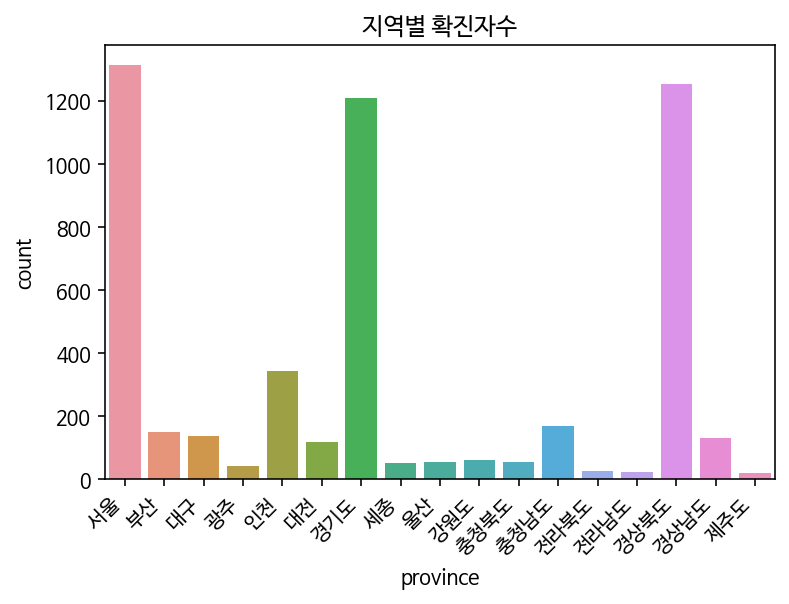

In [41]:
ax = sns.countplot(patientInfo['province'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('지역별 확진자수')
plt.show()

전파자와 **전파자에 의해** 서만 감염된 사람들로 나누어 그래프를 그렸을 때와, 위와 같이 전체 patientInfo 데이터에서 지역별 확진자수를 그래프로 나타내어 비교해보았을 때는 생각보다 큰 차이가 있음을 확인할 수 있다. 특히 **전파자와 전파자에 의해 감염된 사람**으로만 나타내었을 때에는 의외로 충청도 지역의 수가 높게 나왔는데, 지역별 확진자수를 확인해보았을 때에 충청도의 확진자수는 다른 서울, 경기, 경북에 비해 미미한 수임을 확인할 수 있었다.

따라서, 데이터를 직접 확인해보기 위해 "대구 - 신천지" 경우를 선정할 것이다.
대구 신천지로 인해 많은 사람들이 감염되었으므로 대구 전파자 수와, 대구 접촉으로 인해 확진된 사람의 수를 확인해볼 것이다.

In [42]:
daegu = patientInfo[patientInfo['province'] == '대구']
print(len(daegu))

137


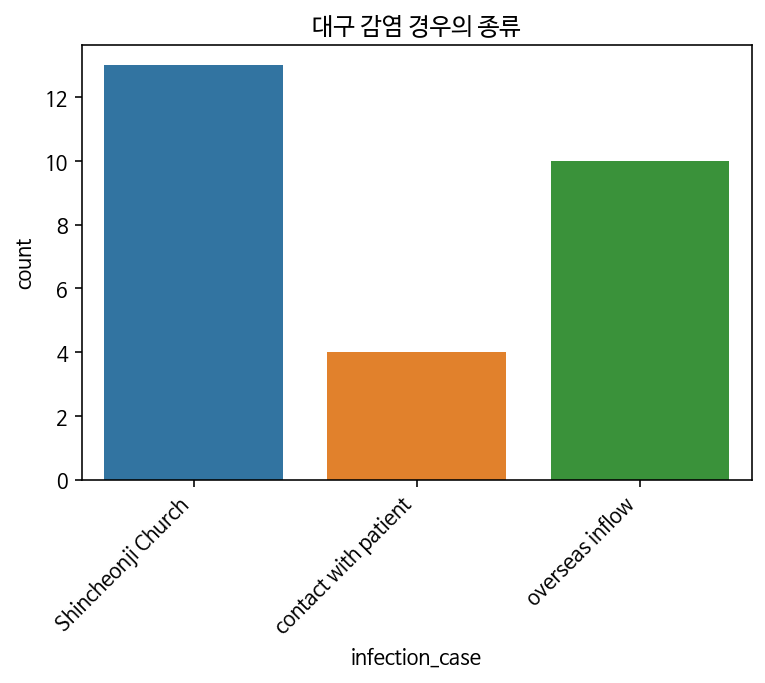

In [43]:
ax = sns.countplot(daegu['infection_case'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('대구 감염 경우의 종류')
plt.show()

대구의 경우를 확인해보려고 하니, 애초에 patientInfo 데이터에서 대구의 경우가 137건밖에 존재하지 않았다. 아래에서 infection case가 신천지인 경우를 확인해보니 총 13건밖에 되지 않았으며 그 중에서 감염의 전파자가 되는 사람은 1200000031번 환자였다.

In [44]:
shincheonji_church = daegu[daegu['infection_case'] == 'Shincheonji Church']
shincheonji_church.head(13)

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
1463,1200000031,female,60s,Korea,대구,NaN,Shincheonji Church,NaN,1160,NaN,2020-02-18,NaN,NaN,isolated
1465,1200000034,male,20s,Korea,대구,중구,Shincheonji Church,NaN,NaN,NaN,2020-02-18,NaN,NaN,isolated
1466,1200000035,female,20s,Korea,대구,남구,Shincheonji Church,NaN,NaN,NaN,2020-02-18,NaN,NaN,isolated
1467,1200000036,female,40s,Korea,대구,남구,Shincheonji Church,NaN,NaN,NaN,2020-02-18,NaN,NaN,isolated
1469,1200000042,female,20s,Korea,대구,남구,Shincheonji Church,NaN,NaN,NaN,2020-02-19,NaN,NaN,isolated
1470,1200000043,female,50s,Korea,대구,달서구,Shincheonji Church,NaN,NaN,NaN,2020-02-19,NaN,NaN,isolated
1471,1200000044,female,40s,Korea,대구,달서구,Shincheonji Church,NaN,NaN,NaN,2020-02-19,NaN,NaN,isolated
1474,1200000047,female,60s,Korea,대구,NaN,Shincheonji Church,1200000031,NaN,NaN,2020-02-19,NaN,NaN,isolated
1475,1200000048,female,70s,Korea,대구,NaN,Shincheonji Church,1200000031,NaN,NaN,2020-02-19,NaN,NaN,isolated
1476,1200000049,male,50s,Korea,대구,NaN,Shincheonji Church,1200000031,NaN,NaN,2020-02-19,NaN,NaN,isolated


위 경우를 통해서, 앞선 데이터분석의 오류를 발견할 수 있었다. 내가 다룬 경우는 contact with patient 경우로서 이 경우가 다른 감염자와의 접촉으로서 걸린 경우라고 생각했는데, infection case가 contact with patient가 아니더라도 infected_by가 존재하는 데이터셋임을 확인할 수 있었다.

따라서, 다시 데이터를 "contact with patient"가 아닌, infected by가 NaN이 아닌 데이터들로 분류해서 같은 작업을 반복해볼 것이다.

In [45]:
#infected_by가 존재하는 경우만 분리
patient_who_infected_by_others_redo = patientInfo[patientInfo['infected_by'].notnull()].reset_index().drop(["index"], axis = 1)
patient_who_infected_by_others_redo = patient_who_infected_by_others_redo[['patient_id','sex','age','country','province','city','infection_case','infected_by']]
patient_who_infected_by_others_redo['province_city'] = patient_who_infected_by_others_redo['province'] + ' ' + patient_who_infected_by_others_redo['city']
print("총 %d개의 데이터가 존재한다." %(len(patient_who_infected_by_others_redo)))
patient_who_infected_by_others_redo.head()

총 1346개의 데이터가 존재한다.


,patient_id,sex,age,country,province,city,infection_case,infected_by,province_city
0,1000000003,male,50s,Korea,서울,종로구,contact with patient,2002000001,서울 종로구
1,1000000005,female,20s,Korea,서울,성북구,contact with patient,1000000002,서울 성북구
2,1000000006,female,50s,Korea,서울,종로구,contact with patient,1000000003,서울 종로구
3,1000000007,male,20s,Korea,서울,종로구,contact with patient,1000000003,서울 종로구
4,1000000010,female,60s,Korea,서울,성북구,contact with patient,1000000003,서울 성북구


In [46]:
print("각 데이터의 널값 비율은 다음과 같다.")
patient_who_infected_by_others_redo.isnull().sum() / len(patient_who_infected_by_others_redo)


각 데이터의 널값 비율은 다음과 같다.


patient_id        0.000000
sex               0.178306
age               0.286033
country           0.000000
province          0.000000
city              0.017088
infection_case    0.000000
infected_by       0.000000
province_city     0.017088
dtype: float64

가장 중요한 infected_by와 patient_id의 널값이 존재하지 않으므로 이대로 진행한다.

In [47]:
patient_who_infected_by_others_redo = patient_who_infected_by_others_redo.reset_index().drop(['index'], axis = 1)

In [48]:
patient_who_infected_by_others_redo.head()
trace_redo = {}
for i in range(len(patient_who_infected_by_others_redo)):
  infected = patient_who_infected_by_others_redo['infected_by'][i]
  patient = patient_who_infected_by_others_redo['patient_id'][i]
  if infected in trace_redo:
    trace_redo[infected].append(patient)
  else:
    trace_redo[infected] = [patient]

In [49]:
getMax = 0
for key, value in trace.items():
  if len(value) > getMax:
    getMax = len(value)
getMax = getMax * 2 + 1

for key in trace_redo:
  if len(trace_redo[key]) < getMax:
    while len(trace_redo[key]) < getMax:
      trace_redo[key].append(0) 

size = []
for key,value in trace_redo.items():
  size.append(len(value))


trace_df = pd.DataFrame(trace_redo)
trace_df = trace_df.T
trace_df = trace_df.reset_index()
trace_df.rename(columns={'index':'beginning'}, inplace = True)
trace_df.to_csv('/content/gdrive/My Drive/dacon/trace_testset_redo.csv')

In [50]:
trace_df_redo = pd.read_csv('/content/gdrive/My Drive/dacon/trace_testset_redo.csv')
trace_df_redo.drop(['Unnamed: 0'], axis=1, inplace=True)

In [51]:
trace_df_redo.head()

,beginning,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206
0,2002000001,1000000003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1000000002,1000000005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1000000003,1000000006,1000000007,1000000010,1000000017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1000000017,1000000013,1000000016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1000000013,1000000014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
trace_df_redo.dtypes

beginning    object
0             int64
1             int64
2             int64
3             int64
              ...  
202           int64
203           int64
204           int64
205           int64
206           int64
Length: 208, dtype: object

In [53]:
i = 0
while i < 3:
  for j in range(207):
    beginning = list(trace_df_redo['beginning'][:])
    if trace_df_redo[str(j)][i] == 0:
      continue
    if str(trace_df_redo[str(j)][i]) in beginning:
      idx = beginning.index(str(trace_df_redo[str(j)][i]))
      tmp = list(trace_df_redo.loc[idx])
      for k in range(len(tmp)):
        if tmp[k] == 0:
          tmp = tmp[1:k]
          break
      for l in range(len(trace_df_redo.loc[idx])):
        if trace_df_redo.loc[i][l] == 0:
          trace_df_redo.iloc[i,l:l+len(tmp)] = tmp
          trace_df_redo.drop([idx], inplace = True)
          trace_df_redo = trace_df_redo.reset_index()
          trace_df_redo.drop(["index"],axis= 1,inplace=True)
          break
  i += 1


In [54]:
trace_df_redo.head()

,beginning,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206
0,2002000001,1000000003,1000000006,1000000007,1000000010,1000000017,1000000013,1000000016,1000000014,1000000021,2000000019,1000000019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1000000002,1000000005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1000000015,1000000020,1000000078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1000000022,1000000025,1000000061,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1000000028,1000000029,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [55]:
dropcol = []
for i in range(0,207):
  tmp = list(trace_df_redo[str(i)])
  if len(set(tmp)) == 1 and tmp[0] == 0:
    dropcol.append(i)

while dropcol:
  j = dropcol.pop()
  trace_df_redo.drop([str(j)],axis=1,inplace= True)


trace_df_redo.head()

,beginning,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,2002000001,1000000003,1000000006,1000000007,1000000010,1000000017,1000000013,1000000016,1000000014,1000000021,2000000019,1000000019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1000000002,1000000005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1000000015,1000000020,1000000078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1000000022,1000000025,1000000061,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1000000028,1000000029,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
trace_df_redo.to_csv('/content/gdrive/My Drive/dacon/update_trace_testset_redo_drop_all_zero.csv')

In [57]:
bg = list(trace_df_redo['beginning'])
tmp = {}

for p_id in bg:
  for i in range(len(patientInfo)):
    if str(patientInfo['patient_id'][i]) == str(p_id):
      tmp[p_id] = [patientInfo['sex'][i],patientInfo['age'][i],patientInfo['province'][i], patientInfo['city'][i], patientInfo['infection_case'][i]]
      break


In [58]:
info_about_beginning_redo_df = pd.DataFrame(tmp)
info_about_beginning_redo_df = info_about_beginning_redo_df.T
info_about_beginning_redo_df = info_about_beginning_redo_df.reset_index()
info_about_beginning_redo_df.rename(columns={'index':'beginning'}, inplace = True)
info_about_beginning_redo_df.columns = ["beginning","sex","age","province","city","infection_case"]
info_about_beginning_redo_df.head()

,beginning,sex,age,province,city,infection_case
0,1000000002,male,30s,서울,중랑구,overseas inflow
1,1000000015,male,70s,서울,성동구,Seongdong-gu APT
2,1000000022,male,30s,서울,서대문구,Eunpyeong St. Mary's Hospital
3,1000000028,female,70s,서울,종로구,Eunpyeong St. Mary's Hospital
4,1000000031,male,50s,서울,송파구,etc


In [59]:
if_case = info_about_beginning_redo_df[['infection_case']]
if_case['count'] = 1
if_case = if_case.groupby(['infection_case']).sum().reset_index()
if_case = if_case.sort_values(by = 'count', ascending=False)
print("환자와의 접촉, 기타, 해외 유입, 쿠팡 물류센터, 이태원 클럽 순")
if_case.head()

환자와의 접촉, 기타, 해외 유입, 쿠팡 물류센터, 이태원 클럽 순


,infection_case,count
26,contact with patient,245
27,etc,133
30,overseas inflow,60
1,Coupang Logistics Center,22
10,Itaewon Clubs,17


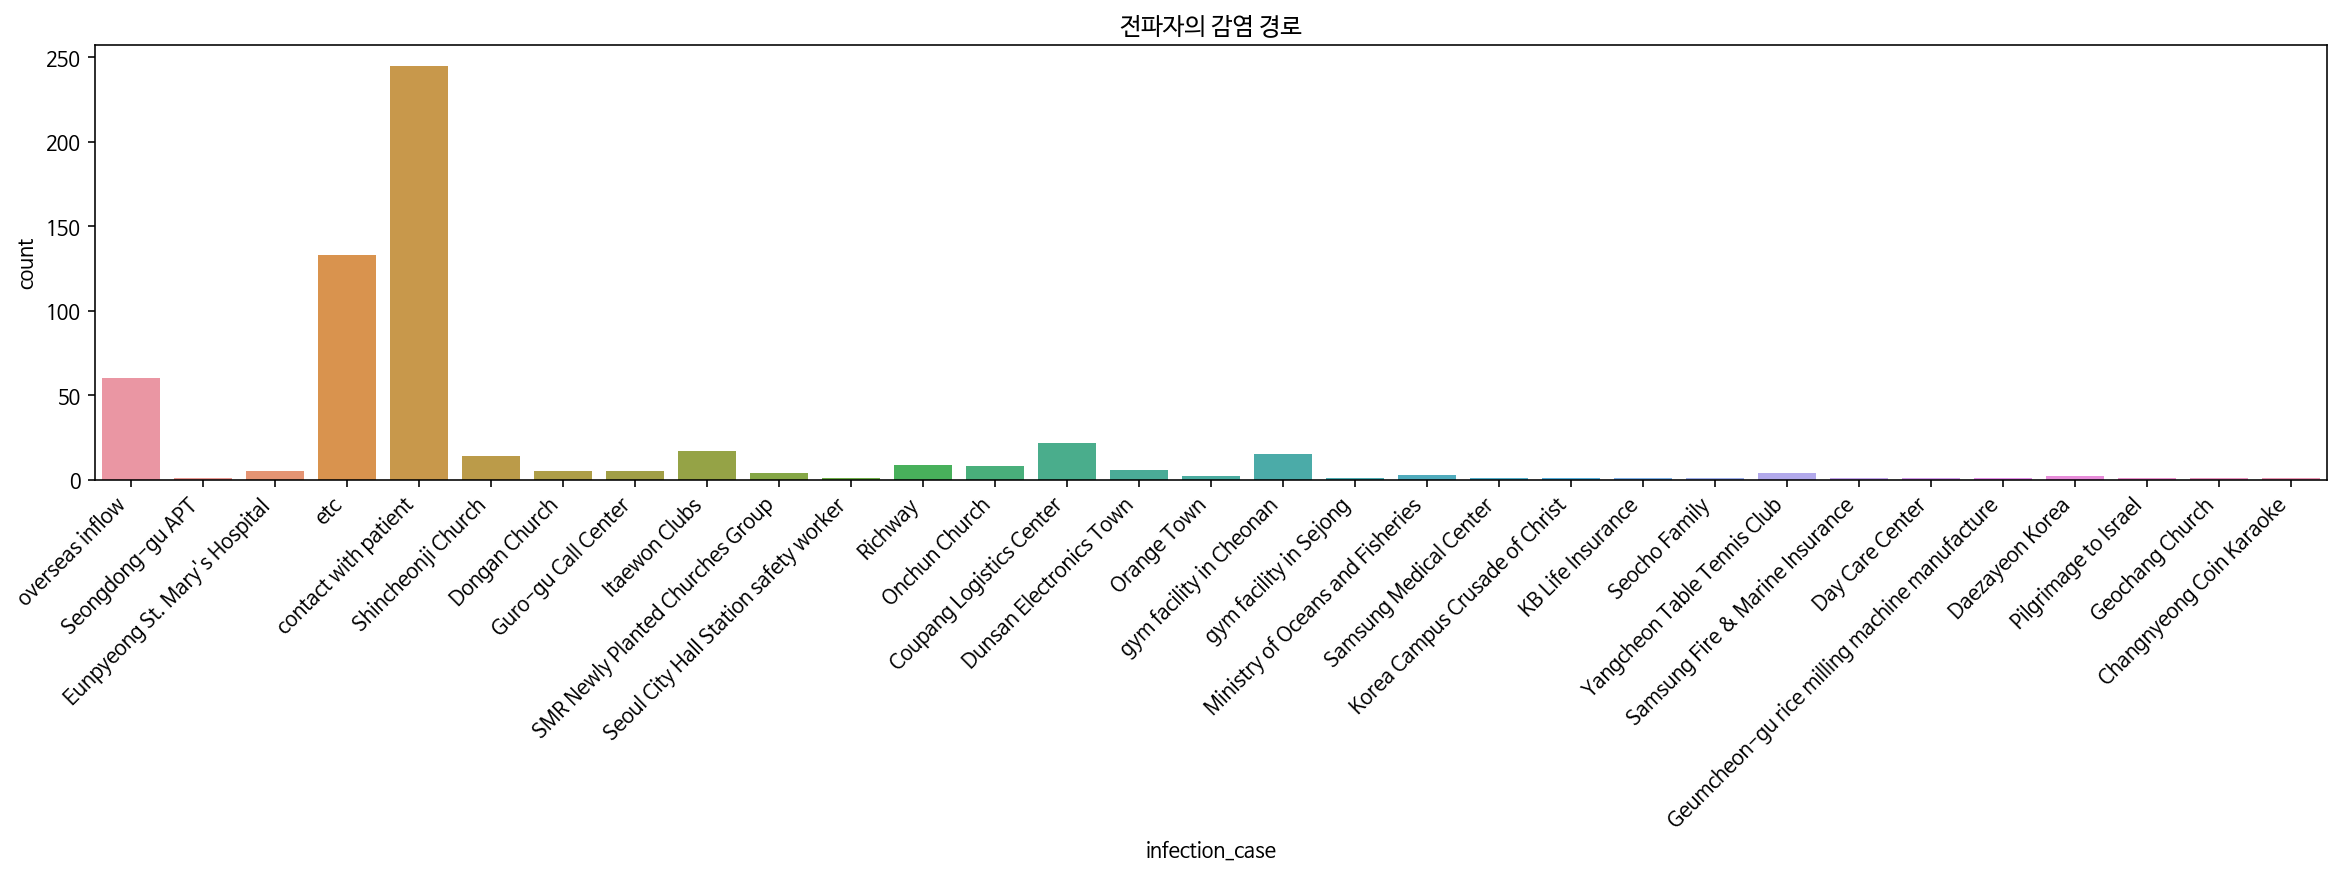

In [60]:
plt.figure(figsize=(20,4)) 
ax = sns.countplot(info_about_beginning_redo_df['infection_case'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('전파자의 감염 경로')
plt.show()

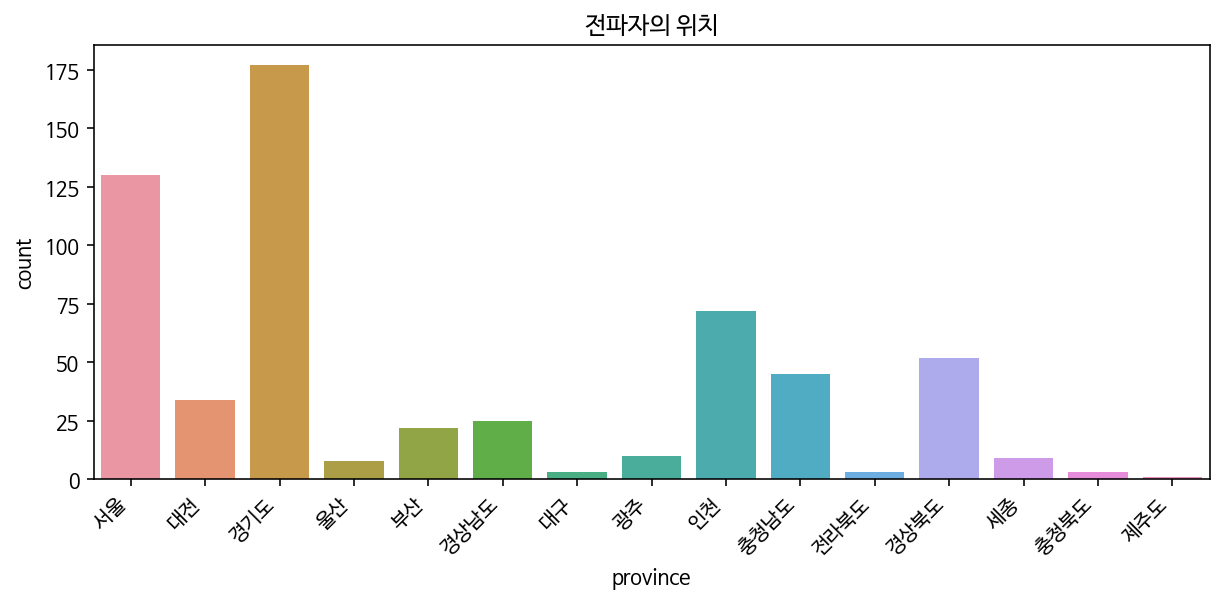

In [61]:
plt.figure(figsize=(10,4)) 
ax = sns.countplot(info_about_beginning_redo_df['province'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('전파자의 위치')
plt.show()

In [62]:
print("각 데이터의 널값 비율은 다음과 같다.")
info_about_beginning_redo_df.isnull().sum() / len(info_about_beginning_redo_df)

각 데이터의 널값 비율은 다음과 같다.


beginning         0.000000
sex               0.153199
age               0.265993
province          0.000000
city              0.018519
infection_case    0.037037
dtype: float64

In [63]:
if type(info_about_beginning_redo_df['city']) is float:
  info_about_beginning_redo_df['location'] = info_about_beginning_redo_df['province']
else:
  info_about_beginning_redo_df['location'] = info_about_beginning_redo_df['province'] + ' ' + info_about_beginning_redo_df['city']

In [64]:
info_about_beginning_redo_df.drop(["city"],axis=1, inplace=True)

전파자의 위치를 province만 나타낸 버전과 location을 모두 나타낸 버전 2가지로 만들어서 비교할 것이다.

In [124]:
location_province = info_about_beginning_redo_df[['province']]
location_province['count'] = 1
location_province = location_province.groupby(['province']).sum().reset_index()

location_total= info_about_beginning_redo_df[['location']]
location_total['count'] = 1
location_total = location_total.groupby(['location']).sum().reset_index()

누군가에 의해 감염된 사람들의 위치 순위를 알아보기 위해 beginning에 속한 사람을 제외한 데이터셋을 만든다.

In [66]:
bg = list(trace_df_redo['beginning'])
p_id = list(patient_who_infected_by_others_redo['patient_id'])
remove_idx = []
for p in bg:
  if p in p_id:
    idx = p_id.index(p)
    remove_idx.append(idx)


remove_bg = patient_who_infected_by_others_redo
for idx in remove_idx:
  remove_bg.drop([idx], inplace=True)

remove_bg.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,province_city
0,1000000003,male,50s,Korea,서울,종로구,contact with patient,2002000001,서울 종로구
1,1000000005,female,20s,Korea,서울,성북구,contact with patient,1000000002,서울 성북구
2,1000000006,female,50s,Korea,서울,종로구,contact with patient,1000000003,서울 종로구
3,1000000007,male,20s,Korea,서울,종로구,contact with patient,1000000003,서울 종로구
4,1000000010,female,60s,Korea,서울,성북구,contact with patient,1000000003,서울 성북구


In [125]:
infectedby_location = remove_bg[['province_city']]
infectedby_location['count'] = 1
infectedby_location = infectedby_location.groupby(['province_city']).sum().reset_index()

infectedby_province = remove_bg[['province']]
infectedby_province['count'] = 1
infectedby_province = infectedby_province.groupby(['province']).sum().reset_index()

In [68]:
location_province.columns = ["province","Number of people who have infected others"]
infectedby_province.columns = ["province","Number of people who infected by others"]
df_merge_1 = pd.merge(location_province, infectedby_province, how='left',on='province')

location_total.columns = ["location","Number of people who have infected others"]
infectedby_location.columns = ["location","Number of people who infected by others"]
df_merge_2 = pd.merge(location_total, infectedby_location, how='left',on='location')

#### province 기준, 전파자의 위치와 전파자에 의해 감염된 전염자의 위치 분포 관계

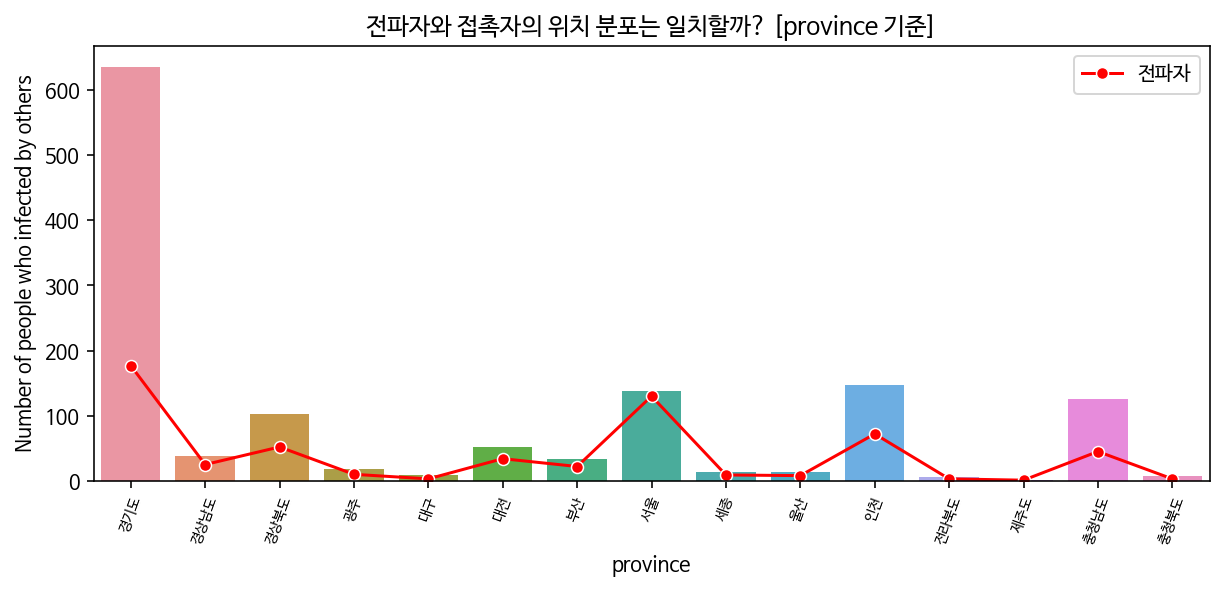

In [69]:
plt.figure(figsize=(10,4)) 
sns.lineplot(x='province', y='Number of people who have infected others', data=df_merge_1, label='전파자',color='red',marker='o')
sns.barplot(x='province',y='Number of people who infected by others',data=df_merge_1)
plt.title('전파자와 접촉자의 위치 분포는 일치할까? [province 기준]')
plt.xticks(rotation=70, fontsize = 7)
plt.show()

#### location(province + city) 기준, 전파자의 위치와 전파자에 의해 감염된 전염자의 위치 분포 관계

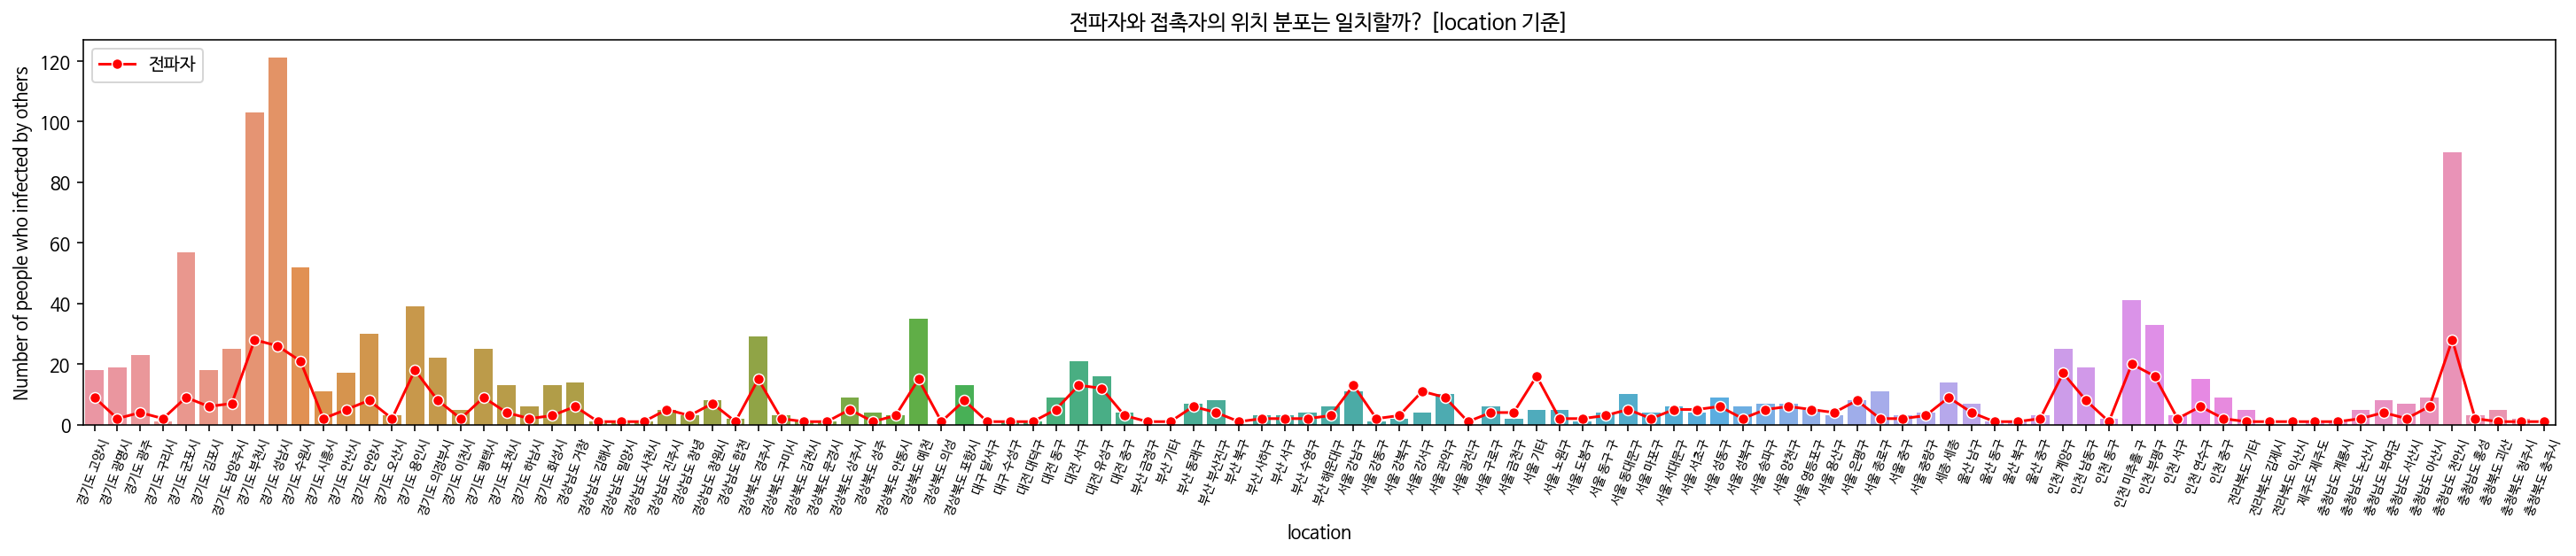

In [70]:
plt.figure(figsize=(25,4)) 
sns.lineplot(x='location', y='Number of people who have infected others', data=df_merge_2, label='전파자',color='red',marker='o')
sns.barplot(x='location',y='Number of people who infected by others',data=df_merge_2)
plt.title('전파자와 접촉자의 위치 분포는 일치할까? [location 기준]')
plt.xticks(rotation=70, fontsize = 7)
plt.show()

드디어.... 전파자와 전염자의 분포의 흐름이 거의 일치함을 확인할 수 있다!!!

### 접촉으로 인한 감염과, 유동인구 간의 관계 (유동인구 데이터는 by Eunsu)

유동인구 데이터가 서울 밖에 없기 때문에, 위 데이터들을 서울만 분리해서 사용할 것이다. 사실 서울은 접촉 감염에서는 별다른 두각을 나타내지 않지만 세부적으로 확인할 수 있을 가능성도 있기에, 비교해보도록 하자!

앞서 전처리한 데이터들 중 province 기준 전파자, 전염자의 데이터에 유동인구로 left merge하여 그래프로 시각화해볼 것이다.

In [71]:
print("전염자")
infectedby_province.head()

전염자


,province,Number of people who infected by others
0,경기도,636
1,경상남도,38
2,경상북도,102
3,광주,18
4,대구,9


In [72]:
print("전파자")
location_province.head()

전파자


,province,Number of people who have infected others
0,경기도,177
1,경상남도,25
2,경상북도,52
3,광주,10
4,대구,3


In [73]:
fpopl = pd.read_csv('/content/gdrive/My Drive/dacon/fpopl.csv')
fpopl.head()

,base_ymd,tmzon_se_code,sexdstn_se_code,agrde_se_code,adstrd_code,popltn_cascnt
0,20200101,0,M,age_00,11650560,15
1,20200101,0,M,age_00,11590620,6
2,20200101,0,M,age_00,11560710,4
3,20200101,0,M,age_00,11470680,12
4,20200101,0,M,age_00,11350665,6


In [74]:
fpopl_by_ads=fpopl[['adstrd_code','popltn_cascnt']]
fpopl_byads=fpopl_by_ads.groupby(by=['adstrd_code'],as_index=False).popltn_cascnt.sum()

fpopl_byads['adstrd_code']=fpopl_byads['adstrd_code'].astype(str)
fpopl_byads['adstrd_code'] = fpopl_byads['adstrd_code'].apply(lambda x:x[:5])

adstrd=pd.read_csv('/content/gdrive/My Drive/dacon/adstrd_master.csv')
adstrd['adstrd_code']=adstrd['adstrd_code'].astype(str)
adstrd['exp']=adstrd['adstrd_code'].apply(lambda x:x[:5])
adstrd['total_adstrd']=adstrd['brtc_nm']+' '+adstrd['signgu_nm']

adstrd_name=adstrd[['exp','total_adstrd']]
adstrd_name=adstrd_name.drop_duplicates(['exp'],keep='first')
adstrd_name=adstrd_name.reset_index()
adstrd_name=adstrd_name.drop(['index'],axis=1)

adstrd_nm={}
for i in range(len(adstrd_name)):
  adstrd_nm[adstrd_name['exp'][i]]=adstrd_name['total_adstrd'][i]

ad_name=[]
for i in range(len(fpopl_byads)):
  ad_name.append(adstrd_nm[fpopl_byads['adstrd_code'][i]])
fpopl_byads['adstrd_code']=ad_name
fpopl_byads.head()

,adstrd_code,popltn_cascnt
0,서울특별시 종로구,10137919
1,서울특별시 종로구,29509247
2,서울특별시 종로구,5364581
3,서울특별시 종로구,14516260
4,서울특별시 종로구,16090967


In [75]:
fpopl_byads = fpopl_byads.groupby(['adstrd_code']).sum().reset_index()

In [96]:
fpopl_byads['average count'] = 0.0000
fpopl_byads.head()

,location,population count,average count
0,서울특별시 강남구,787214018,0.0
1,서울특별시 강동구,383373291,0.0
2,서울특별시 강북구,171639290,0.0
3,서울특별시 강서구,401808239,0.0
4,서울특별시 관악구,313740325,0.0


In [97]:
total_popl_count = sum(fpopl_byads['population count'])

for i in range(len(fpopl_byads)):
  value = float(fpopl_byads['population count'][i] / total_popl_count)
  fpopl_byads['average count'][i] = float(value)

fpopl_byads.head()

,location,population count,average count
0,서울특별시 강남구,787214018,0.088680
1,서울특별시 강동구,383373291,0.043187
2,서울특별시 강북구,171639290,0.019335
3,서울특별시 강서구,401808239,0.045264
4,서울특별시 관악구,313740325,0.035343


In [111]:
def replaceSeoul(df):
  for i in range(len(df)):
    text = df['location'][i]
    if '서울' in df['location'][i]:
      text = text.strip()
      text = text[2:]
      text = '서울특별시'+text
      df['location'][i] = text

In [127]:
location_total.columns = ["location","Number of people who have infected others"]
infectedby_location.columns = ["location","Number of people who infected by others"]
replaceSeoul(infectedby_location)
replaceSeoul(location_total)
location_popl = fpopl_byads.drop(["population count"], axis=1)

In [128]:
for i in range(len(infectedby_location)):
  if '서울' in infectedby_location['location'][i]:
    print(infectedby_location['location'][i])

서울특별시 강남구
서울특별시 강동구
서울특별시 강북구
서울특별시 강서구
서울특별시 관악구
서울특별시 구로구
서울특별시 금천구
서울특별시 기타
서울특별시 노원구
서울특별시 도봉구
서울특별시 동구 구
서울특별시 동대문구
서울특별시 마포구
서울특별시 서대문구
서울특별시 서초구
서울특별시 성동구
서울특별시 성북구
서울특별시 송파구
서울특별시 양천구
서울특별시 영등포구
서울특별시 용산구
서울특별시 은평구
서울특별시 종로구
서울특별시 중구
서울특별시 중랑구


In [145]:
df_merge_tmp = pd.merge(location_total, infectedby_location, how = 'left', on='location')
location_popl.columns = ["location","average count"]
df_merge_all = pd.merge(fpopl_byads, df_merge_tmp, how= 'left', on = 'location')

In [146]:
df_merge_all.head()

,location,population count,average count,Number of people who have infected others,Number of people who infected by others
0,서울특별시 강남구,787214018,0.088680,13.0,11.0
1,서울특별시 강동구,383373291,0.043187,2.0,1.0
2,서울특별시 강북구,171639290,0.019335,3.0,2.0
3,서울특별시 강서구,401808239,0.045264,11.0,4.0
4,서울특별시 관악구,313740325,0.035343,9.0,10.0


In [147]:
df_merge_all = df_merge_all.dropna()
df_merge_all = df_merge_all.reset_index()
df_merge_all.drop(['index'],axis=1,inplace = True)

total_by_others_count = sum(df_merge_all['Number of people who infected by others'])
total_have_infected_count = sum(df_merge_all['Number of people who have infected others'])

print(total_by_others_count)
print(total_have_infected_count)


for i in range(len(df_merge_all)):
  value1 = float(df_merge_all['Number of people who infected by others'][i] / total_by_others_count)
  value2 = float(df_merge_all['Number of people who have infected others'][i] / total_have_infected_count)
  df_merge_all['Number of people who have infected others'][i] = float(value2)
  df_merge_all['Number of people who infected by others'][i] = float(value1)

df_merge_all.head()

129.0
110.0


,location,population count,average count,Number of people who have infected others,Number of people who infected by others
0,서울특별시 강남구,787214018,0.088680,0.118182,0.085271
1,서울특별시 강동구,383373291,0.043187,0.018182,0.007752
2,서울특별시 강북구,171639290,0.019335,0.027273,0.015504
3,서울특별시 강서구,401808239,0.045264,0.100000,0.031008
4,서울특별시 관악구,313740325,0.035343,0.081818,0.077519


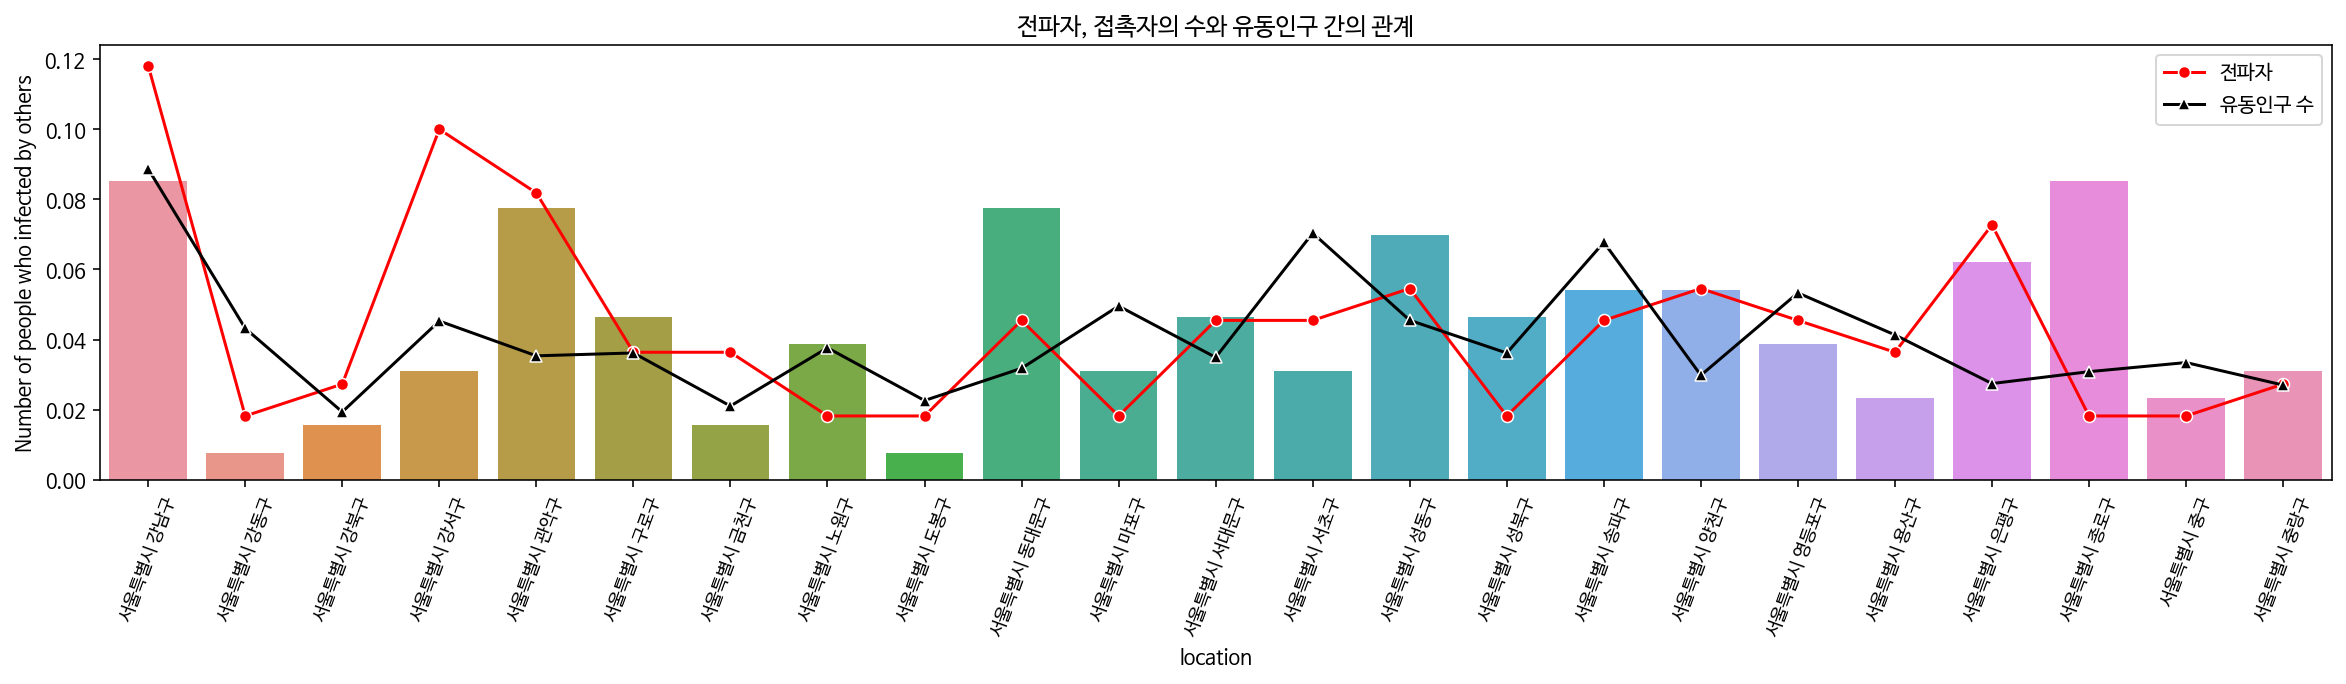

In [150]:
plt.figure(figsize=(20,4)) 
sns.lineplot(x='location', y='Number of people who have infected others', data=df_merge_all, label='전파자',color='red',marker='o')
sns.lineplot(x='location', y='average count', data=df_merge_all, label='유동인구 수',color='black',marker='^')
sns.barplot(x='location',y='Number of people who infected by others',data=df_merge_all)
plt.title('전파자, 접촉자의 수와 유동인구 간의 관계')
plt.xticks(rotation=70, fontsize = 9)
plt.show()

### 한 전파자는 최대 어느 지역까지 전파할 수 있을까?

In [78]:
!pip install haversine

In [79]:
from haversine import haversine

위도, 경도 값으로 두 지역간의 거리를 구하기 위해 haversine 모듈을 import한다.

In [80]:
region = pd.read_csv('/content/gdrive/My Drive/dacon/COVID_19/Region.csv')
region_code = region[['code','province','city', 'latitude','longitude']]
region_code['province_city'] = ''
for i in range(len(region_code)):
  if region_code['province'][i] == region_code['city'][i]:
    region_code['province_city'][i] = region_code['province'][i]
  else:
    region_code['province_city'][i] = region_code['province'][i] +' '+region_code['city'][i]
region_code = region_code[['code','province_city', 'latitude','longitude']]
region_code.head()

,code,province_city,latitude,longitude
0,10000,서울,37.566953,126.977977
1,10010,서울 강남구,37.518421,127.047222
2,10020,서울 강동구,37.530492,127.123837
3,10030,서울 강북구,37.639938,127.025508
4,10040,서울 강서구,37.551166,126.849506


In [81]:
test_trace_df.head()

,beginning,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
0,2002000001,1000000003,1000000006,1000000007,1000000010,1000000017,1000000013,1000000016,1000000014,1000000021,2000000019,1000000019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1000000002,1000000005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1000000031,1000000033,1000000034,1000000037,1000000045,1000000067,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1000000041,1000000046,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1000000047,1000000064,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [82]:
patientInfo.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,서울,강서구,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,서울,중랑구,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,서울,종로구,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,서울,마포구,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,서울,성북구,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


전파자의 위치와 전파자에 의해서 감염된 감염자들의 위치를 dictionary 형태로 나타냄.

In [83]:
#예시 {서울시 강남구 : [서울시 강남구, 서울시 영등포구, 서울시 동작구], 경기도 부천시: [경기도 부천시, 대구 서구]}
patientInfo_list = list(patientInfo['patient_id'])

location_mapping = dict()
for i in range(len(test_trace_df)):
  p_id = test_trace_df['beginning'][i]
  if p_id in patientInfo_list:
    idx = patientInfo_list.index(p_id)
    if type(patientInfo['city'][idx]) is float:
      location = patientInfo['province'][idx]
    else:
      location = patientInfo['province'][idx] +' '+ patientInfo['city'][idx]
    infected_location_list = []
    for j in range(0,66):
      if test_trace_df[str(j)][i] in patientInfo_list:
        mini_idx = patientInfo_list.index(test_trace_df[str(j)][i])
        mini_loc = patientInfo['province'][mini_idx] +' '+ patientInfo['city'][mini_idx]
        infected_location_list.append(mini_loc)
    location_mapping[location] = infected_location_list

print(location_mapping)          

{'서울 중랑구': ['경기도 용인시', '경기도 수원시'], '서울 송파구': ['경기도 안산시'], '서울 강동구': ['서울 기타'], '서울 강남구': ['충청남도 공주시'], '서울 강북구': ['서울 강북구', '서울 강북구'], '서울 양천구': ['서울 양천구', '서울 양천구'], '서울 관악구': ['서울 관악구'], '서울 성북구': ['서울 성북구', '서울 성북구', '경기도 성남시'], '서울 기타': ['경기도 의왕시'], '서울 동대문구': ['서울 성북구'], '서울 은평구': ['서울 은평구'], '서울 마포구': ['서울 마포구'], '서울 영등포구': ['서울 영등포구', '서울 영등포구', '서울 양천구'], '서울 용산구': ['경기도 고양시'], '서울 강서구': ['경기도 용인시', '경기도 양주시'], '서울 성동구': ['서울 성동구'], '서울 서대문구': ['서울 서대문구'], '서울 종로구': ['서울 종로구'], '서울 금천구': ['경기도 시흥시'], '서울 동구 구': ['경기도 수원시'], '서울 서초구': ['경기도 수원시'], '부산 서구': ['부산 서구'], '부산 해운대구': ['부산 해운대구'], '부산 북구': ['부산 해운대구'], '부산 동래구': ['부산 동래구'], '부산 사하구': ['부산 사하구'], '부산 수영구': ['부산 수영구', '부산 수영구'], '경상남도 창녕': ['경상남도 창녕'], '부산 부산진구': ['부산 부산진구', '부산 부산진구', '부산 부산진구'], '대구': ['대구 중구', '대전 유성구', '경기도 김포시', '경기도 부천시', '경기도 용인시', '경기도 남양주시', '경상북도 경주시', '경상북도 경주시', '경상북도 경주시', '경상남도 양산', '경기도 김포시', '경기도 김포시', '경기도 부천시', '경기도 부천시', '경기도 남양주시'], '대구 달서구': ['대구 수성구', '대구 북구'], '대전 동구': ['대전 서구'], '

folium 사용법 참조: https://www.kaggle.com/mbnb8317/ds4c-tutorial-all-about-folium-pydeck

In [84]:
m = folium.Map([36, 128], zoom_start=7) 

plugins.MousePosition().add_to(m) ## you can easily get coordinates.
m

In [85]:
regional_patient = pd.merge(patientInfo[['patient_id','confirmed_date','sex','age','province','city']],region[['province','city','latitude','longitude']], how = 'left', on = ['province','city'])
display(regional_patient.head())
display(regional_patient.isnull().sum() / regional_patient.shape[0])
print('서울과 인천, 경북지역의 감염자 수가 가장 높음을 알 수 있다.')

,patient_id,confirmed_date,sex,age,province,city,latitude,longitude
0,1000000001,2020-01-23,male,50s,서울,강서구,37.551166,126.849506
1,1000000002,2020-01-30,male,30s,서울,중랑구,37.606832,127.092656
2,1000000003,2020-01-30,male,50s,서울,종로구,37.572999,126.979189
3,1000000004,2020-01-30,male,20s,서울,마포구,37.566283,126.901644
4,1000000005,2020-01-31,female,20s,서울,성북구,37.589562,127.016700


patient_id        0.000000
confirmed_date    0.000581
sex               0.217231
age               0.267183
province          0.000000
city              0.018199
latitude          0.042401
longitude         0.042401
dtype: float64

서울과 인천, 경북지역의 감염자 수가 가장 높음을 알 수 있다.


### 접촉으로 인한 감염과, 인구밀도 간의 관계